# 주가 예측 모델 구축

## Dataset: 삼성전자 주가 데이터

## 1. 주가 데이터 로드

### 컬럼 설명

- `Open`:   시가
- `High`:   고가
- `Low`:    저가
- `Close`:  종가
- `Volume`: 거래량
- `Change`: 대비

In [1]:
# FinanceDataReader 미설치 시 데이터 직접 로드

import pandas as pd
samsung=pd.read_csv('./datas/samsung_stock.csv', index_col='Date')

In [2]:
# 주가 데이터프레임의 형태 살펴보기

display(samsung.head(5))
display(samsung.tail(5))

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1999-02-09,1682,1698,1657,1675,381820,NaN
1999-02-10,1653,1675,1604,1634,664282,-0.024478
1999-02-11,1661,1678,1643,1644,287590,0.006120
1999-02-12,1682,1751,1667,1743,403600,0.060219
1999-02-18,1712,1721,1682,1687,440930,-0.032129


,Open,High,Low,Close,Volume,Change
Date,,,,,,
2023-05-19,67800,68400,67500,68400,20349345,0.033233
2023-05-22,68400,69000,68000,68500,14470308,0.001462
2023-05-23,68500,68700,68100,68400,8561643,-0.001460
2023-05-24,68100,68700,68000,68500,8192896,0.001462
2023-05-25,69900,70000,68700,68800,14099597,0.004380


<Axes: xlabel='Date'>

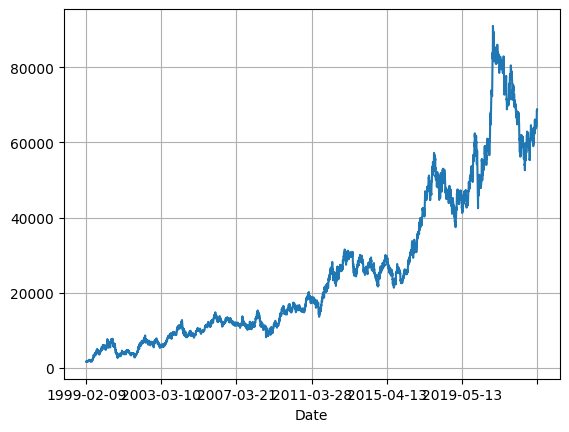

In [3]:
# 주가 그래프 시각화

samsung.Close.plot(grid=True)

## 2. Data Preprocessing

In [4]:
# 2020-01-01 부터 2021-12-31 까지를 학습 데이터로 활용
# 2022-01-01 부터 현재까지를 테스트 데이터로 활용

train = samsung.loc[(samsung.index >= '2020-01-01') & (samsung.index < '2022-01-01')] 
test = samsung.loc[(samsung.index >= '2022-01-01')]

In [5]:
# 예측 모델링을 위한 X, y 정의 (X: Close를 제외한 값, Y: Close) -> Open, High, Low, Volume, Change를 이용해서 Close를 예측하는 task

X_train_org, y_train_org = train.drop(["Close","Change"], axis=1), train.Close
X_test_org, y_test_org = test.drop(["Close", "Change"], axis=1), test.Close

In [6]:
X_train_org

,Open,High,Low,Volume
Date,,,,
2020-01-02,55500,56000,55000,12993228
2020-01-03,56000,56600,54900,15422255
2020-01-06,54900,55600,54600,10278951
2020-01-07,55700,56400,55600,10009778
2020-01-08,56200,57400,55900,23501171
...,...,...,...,...
2021-12-24,80200,80800,80200,12086380
2021-12-27,80600,80600,79800,10783368
2021-12-28,80200,80400,79700,18226325


In [7]:
y_train_org

Date
2020-01-02    55200
2020-01-03    55500
2020-01-06    55500
2020-01-07    55800
2020-01-08    56800
              ...  
2021-12-24    80500
2021-12-27    80200
2021-12-28    80300
2021-12-29    78800
2021-12-30    78300
Name: Close, Length: 496, dtype: int64

In [8]:
X_test_org

,Open,High,Low,Volume
Date,,,,
2022-01-03,79400,79800,78200,13502112
2022-01-04,78800,79200,78300,12427416
2022-01-05,78800,79000,76400,25470640
2022-01-06,76700,77600,76600,12931954
2022-01-07,78100,78400,77400,15163757
...,...,...,...,...
2023-05-19,67800,68400,67500,20349345
2023-05-22,68400,69000,68000,14470308
2023-05-23,68500,68700,68100,8561643


In [9]:
y_test_org

Date
2022-01-03    78600
2022-01-04    78700
2022-01-05    77400
2022-01-06    76900
2022-01-07    78300
              ...  
2023-05-19    68400
2023-05-22    68500
2023-05-23    68400
2023-05-24    68500
2023-05-25    68800
Name: Close, Length: 345, dtype: int64

In [10]:
# feature scaling

from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler_X = MinMaxScaler()
X_train_arr = scaler_X.fit_transform(X_train_org)
X_test_arr = scaler_X.transform(X_test_org)

scaler_y = MinMaxScaler()
y_train_arr = scaler_y.fit_transform(y_train_org.values.reshape(-1,1))
y_test_arr = scaler_y.transform(y_test_org.values.reshape(-1,1))


In [11]:
# 시계열 형태의 데이터로 전환

import numpy as np

def build_timeseries_dataset(X, y, seq_length):
    X_list = []
    y_list = []
    for i in range(len(X)-seq_length):
        seq = X[i:i+seq_length]
        label = y[i+seq_length]
        
        X_list.append(seq)
        y_list.append(label)

    
    return np.array(X_list), np.array(y_list)

In [12]:
# 시계열 형태의 데이터로 전환

WINDOW_SIZE=10

X_train, y_train = build_timeseries_dataset(X_train_arr, y_train_arr, WINDOW_SIZE)
X_test, y_test = build_timeseries_dataset(X_test_arr, y_train_arr, WINDOW_SIZE)


print('Training shape:', X_train.shape, y_train.shape)
print('Test shape:', X_test.shape, y_test.shape)

Training shape: (486, 10, 4) (486, 1)
Test shape: (335, 10, 4) (335, 1)


In [13]:
# numpy array를 모두 torch tensor 형태로 전환

import torch

X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()

y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()

print('Training shape:', X_train.shape, y_train.shape)
print('Test shape:', X_test.shape, y_test.shape)

Training shape: torch.Size([486, 10, 4]) torch.Size([486, 1])
Test shape: torch.Size([335, 10, 4]) torch.Size([335, 1])


In [14]:
# Dataset 정의

from torch.utils.data import Dataset

class Dataset(Dataset):
    
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
    
        return len(self.X)

    def __getitem__(self, idx):

        return self.X[idx], self.Y[idx]
    
train_dataset = Dataset(X_train, y_train)
test_dataset = Dataset(X_test, y_test)


In [17]:
#DataLoader 정의


from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size = 8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size =8, shuffle=False)

## 3. Model Building

In [18]:
# 모델 정의

import torch.nn as nn

class Net(nn.Module):
    def __init__(self, input_size, rnn_h_size, fnn_h_size):
        super(Net, self).__init__()
        
        # RNN 함수 정의
        self.rnn = nn.RNN(input_size= input_size, hidden_size=rnn_h_size, num_layers=1, batch_first=True)
        #self.rnn = nn.LSTM(input_size= input_size, hidden_size=rnn_h_size, num_layers=1, batch_first=True)
        #self.rnn = nn.GRU(input_size= input_size, hidden_size=rnn_h_size, num_layers=1, batch_first=True)

        # fully-connected layer 함수 정의
        self.fc1 = nn.Linear(rnn_h_size, fnn_h_size)
        self.fc2 = nn.Linear(fnn_h_size, 1)

        # nonlinearity - ReLU 함수 정의
        self.relu = nn.ReLU()


    
    def forward(self, x):
        
        # RNN layer 
        x, _ = self.rnn(x)
        #x, (hidden, c) = self.rnn(x)

        # fully-connected layers
        x = self.fc1(x[:,-1])
        x = self.relu(x)
        x = self.fc2(x)

        return x



In [19]:
input_size = X_train.shape[-1]
rnn_h_size = input_size
fnn_h_size = 128

net = Net(input_size = input_size, rnn_h_size = rnn_h_size, fnn_h_size = fnn_h_size )

## 4. Define a Loss Function and Optimizer

In [20]:
# hyperparameter 설정

learning_rate = 1e-4
num_epochs = 200

In [21]:
# loss function 및 optimizer 설정

import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

## 5. Train the Network

In [22]:
from sklearn.metrics import mean_squared_error

In [23]:
# 여러 epoch을 반복하며 RNN 모델 학습

for epoch in range(num_epochs):

    running_loss = 0.0
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


    
        # 전체 test set에 대한 RMSE, MAE, R2
        pred_list = []


    # 모델 평가 시에는 gradient 계산을 할 필요가 없음
    with torch.no_grad():
        for data in test_loader:
            sequences, labels = data
            
            # 예측값 출력
            pred = net(sequences)
            pred_list.append(pred)

    pred_list = np.vstack(pred_list)
    pred_inverse = scaler_y.inverse_transform(pred_list)

    true_labels = y_test_org[10:]

    rmse = mean_squared_error(pred_inverse, true_labels)**0.5

    print('epoch: %d, iter: %d, loss: %.6f test rmse: %.6f'%((epoch+1), i, loss.item(), rmse))
            
    
    print('%d epoch processed...'%(epoch+1))

print('Finished Training')

epoch: 1, iter: 60, loss: 0.265532 test rmse: 13844.967241
1 epoch processed...
epoch: 2, iter: 60, loss: 0.066697 test rmse: 6599.051742
2 epoch processed...
epoch: 3, iter: 60, loss: 0.040593 test rmse: 4349.321207
3 epoch processed...
epoch: 4, iter: 60, loss: 0.015992 test rmse: 5502.423811
4 epoch processed...
epoch: 5, iter: 60, loss: 0.021904 test rmse: 6061.940794
5 epoch processed...
epoch: 6, iter: 60, loss: 0.029951 test rmse: 6169.192359
6 epoch processed...
epoch: 7, iter: 60, loss: 0.022206 test rmse: 6008.634841
7 epoch processed...
epoch: 8, iter: 60, loss: 0.023420 test rmse: 5827.510987
8 epoch processed...
epoch: 9, iter: 60, loss: 0.032739 test rmse: 5552.531664
9 epoch processed...
epoch: 10, iter: 60, loss: 0.024257 test rmse: 5545.169843
10 epoch processed...
epoch: 11, iter: 60, loss: 0.020328 test rmse: 5307.203655
11 epoch processed...
epoch: 12, iter: 60, loss: 0.007457 test rmse: 5177.114617
12 epoch processed...
epoch: 13, iter: 60, loss: 0.012625 test rmse

In [24]:
# 학습된 모델 저장하기

PATH = './samsung_stock_rnn.pth'
torch.save(net.state_dict(), PATH)

In [25]:
# 저장된 모델의 Parameter 불러오기

net = Net(input_size = X_train.shape[-1], rnn_h_size = rnn_h_size, fnn_h_size = fnn_h_size)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 5. Test the Network on the Test Data

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [27]:
# 전체 test set에 대한 RMSE, MAE, R2

pred_list = []


# 모델 학습을 종료하였으므로 gradient 계산을 할 필요가 없음
with torch.no_grad():
    for data in test_loader:
        sequences, labels = data
        
        # 예측값 출력
        pred = net(sequences)
        pred_list.append(pred)

pred_list = np.vstack(pred_list)
pred_inverse = scaler_y.inverse_transform(pred_list)

true_labels = y_test_org[10:]

rmse = mean_squared_error(pred_inverse, true_labels)**0.5
mae = mean_absolute_error(pred_inverse, true_labels)
r2 = r2_score(pred_inverse, true_labels)

print('2023-01-01 부터 현재까지 주가에 대한 RMSE:', rmse)
print('2023-01-01 부터 현재까지 주가에 대한 MAE:', mae)
print('2023-01-01 부터 현재까지 주가에 대한 R2:', r2)

2023-01-01 부터 현재까지 주가에 대한 RMSE: 1016.6038318957028
2023-01-01 부터 현재까지 주가에 대한 MAE: 827.6392257462686
2023-01-01 부터 현재까지 주가에 대한 R2: 0.9643503942925215


In [28]:
true_labels

Date
2022-01-17    77500
2022-01-18    77000
2022-01-19    76300
2022-01-20    76500
2022-01-21    75600
              ...  
2023-05-19    68400
2023-05-22    68500
2023-05-23    68400
2023-05-24    68500
2023-05-25    68800
Name: Close, Length: 335, dtype: int64

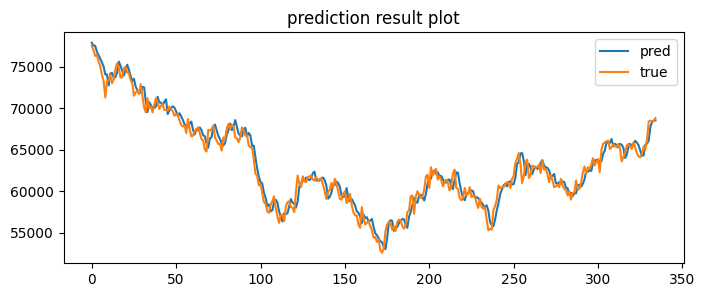

In [29]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(8,3))
plt.plot(np.arange(len(pred_inverse)), pred_inverse, label = 'pred')
plt.plot(np.arange(len(true_labels)), true_labels, label = 'true')

plt.title("prediction result plot")

plt.legend()
plt.show()